<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imitation-learning" data-toc-modified-id="Imitation-learning-1">Imitation learning</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1.2">Preparing the data</a></span></li><li><span><a href="#Creating-the-model" data-toc-modified-id="Creating-the-model-1.3">Creating the model</a></span><ul class="toc-item"><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-1.3.1">Building the model</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.4">Train</a></span><ul class="toc-item"><li><span><a href="#Trainings" data-toc-modified-id="Trainings-1.4.1">Trainings</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.5">Summary</a></span></li></ul></li></ul></div>

# Imitation learning

On this notebook I will try to improve the agent using the ideas of the second iteration.

## Imports

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import glob
import os
from sklearn.preprocessing import OneHotEncoder

import tensorflow.keras as keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Input, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from animalai.envs import UnityEnvironment
from animalai.envs.arena_config import ArenaConfig

## Preparing the data

In [2]:
def load_games_data(game_filepaths):
    data = [np.load(game_filepath) for game_filepath in tqdm(game_filepaths, desc='Loading recorded games')]
    ohe = OneHotEncoder(categories=[range(3)], sparse=False)
    previous_action = np.concatenate([game['previous_action'] for game in data], axis=0)[:, 0]
    ohe.fit(previous_action[:, 1:2])
    previous_action = [ohe.transform(previous_action[:, 0:1]), ohe.transform(previous_action[:, 1:2])]
    previous_action = np.concatenate(previous_action, axis=1)
    model_input = {
        'frame': np.concatenate([game['frame'] for game in data], axis=0),
        'speed': np.concatenate([game['speed'] for game in data], axis=0)[:, 0]/10,
        'previous_action': previous_action,
    }
    action = np.concatenate([game['action'] for game in data], axis=0)
    model_output = {
        'action_move': ohe.transform(action[:, 0:1]),
        'action_rotate': ohe.transform(action[:, 1:2]),
    }
    return model_input, model_output

In [3]:
def mirror_game(game_data):
    return _mirror_input_data(game_data[0]), _mirror_output_data(game_data[1])
    
def _mirror_input_data(input_data):
    mirror_input_data = input_data.copy()
    mirror_input_data['frame'] = np.flip(mirror_input_data['frame'], axis=2)
    mirror_input_data['previous_action'] = mirror_input_data['previous_action'][:, [0, 1, 2, 3, 5, 4]]
    return mirror_input_data

def _mirror_output_data(output_data):
    mirror_output_data = output_data.copy()
    mirror_output_data['action_rotate'] = mirror_output_data['action_rotate'][:, [0, 2, 1]]
    return mirror_output_data

In [4]:
def duplicate_games(game_data):
    mirror_game_data = mirror_game(game_data)
    input_data, output_data = {}, {}
    for key in game_data[0]:
        input_data[key] = np.concatenate([game_data[0][key], mirror_game_data[0][key]], axis=0)
    for key in game_data[1]:
        output_data[key] = np.concatenate([game_data[1][key], mirror_game_data[1][key]], axis=0)
    return input_data, output_data

In [5]:
game_filepaths = glob.glob(os.path.join('/media/guillermo/Data/Kaggle/animalai/gameplay', '*', '*.npz'))

game_filepaths = sorted(game_filepaths)
np.random.seed(7)
np.random.shuffle(game_filepaths)
len(game_filepaths)

101

In [6]:
train = load_games_data(game_filepaths[:-int(len(game_filepaths)//5)])
val = load_games_data(game_filepaths[-int(len(game_filepaths)//5):])

train = duplicate_games(train)
val = duplicate_games(val)

print('Number of train samples: %i' % len(train[0]['frame']))
print('Number of validation samples: %i' % len(val[0]['frame']))


Number of train samples: 7894
Number of validation samples: 1660


## Creating the model

The idea is to process the frame using a lenet like network and merge it later with speed and previous move to take a decision over the actions.

![](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)

### Building the model

In [7]:
def build_model(conv_filters, mlp_units):
    frame = Input(shape=(84, 84, 3), name='frame')
    output = frame
    for n_filters in conv_filters:
        output = Conv2D(filters=n_filters, kernel_size=(3, 3), activation='relu')(output)
        if int(output.get_shape()[1]) >= 2:
            output = MaxPool2D()(output)
    output = Flatten()(output)
    
    speed = Input(shape=(3), name='speed')
    previous_action = Input(shape=(6), name='previous_action')
    
    output = Concatenate()([output, speed, previous_action])
    
    for n_units in mlp_units:
        output = Dense(n_units, activation='relu')(output)
    
    action_move = Dense(3, activation='softmax', name='action_move')(output)
    action_rotate = Dense(3, activation='softmax', name='action_rotate')(output)
    
    model = Model(inputs=dict(frame=frame, speed=speed, previous_action=previous_action), outputs=[action_move, action_rotate])
    return model

## Train

In [8]:
def train_model(conv_filters, mlp_units):
    model = build_model(conv_filters, mlp_units)
    model.summary()
    model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='loss', patience=2, factor=0.7, verbose=1)
    ]
    hist = model.fit(x=train[0], y=train[1], epochs=500, validation_data=val, callbacks=callbacks)
    plot_hist(hist.history)
    return model
    
def plot_hist(hist):
    plt.figure(figsize=(25, 5))
    keys = ['loss']
    for key in keys:
        prefix = ''
        label = '%s%s' % (prefix, key)
        best_score = np.min(hist[label])
        plt.plot(hist[label], label='%s %.4f' % (label, best_score))
        print('%s %.4f' % (label, best_score))
        
        plt.twinx()
        prefix = 'val_'
        label = '%s%s' % (prefix, key)
        best_score = np.min(hist[label])
        plt.plot(hist[label], label='%s %.4f' % (label, best_score), color='orange')
        print('%s %.4f' % (label, best_score))
    plt.legend(loc=0)

### Trainings

W0721 11:02:19.657679 139811613792064 deprecation.py:506] From /home/guillermo/miniconda3/envs/animal/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 41, 41, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 39, 39, 8)    584         max_pooling2d[0][0]              
______________________________________________________________________________________________

7894/7894 [==============================] - 2s 214us/sample - loss: 0.4247 - action_move_loss: 0.2056 - action_rotate_loss: 0.2187 - action_move_acc: 0.9182 - action_rotate_acc: 0.9144 - val_loss: 0.4656 - val_action_move_loss: 0.2188 - val_action_rotate_loss: 0.2462 - val_action_move_acc: 0.9151 - val_action_rotate_acc: 0.9133
Epoch 14/500
7894/7894 [==============================] - 2s 213us/sample - loss: 0.4253 - action_move_loss: 0.2047 - action_rotate_loss: 0.2210 - action_move_acc: 0.9206 - action_rotate_acc: 0.9154 - val_loss: 0.4773 - val_action_move_loss: 0.2256 - val_action_rotate_loss: 0.2512 - val_action_move_acc: 0.9108 - val_action_rotate_acc: 0.9048
Epoch 15/500
7894/7894 [==============================] - 2s 220us/sample - loss: 0.4141 - action_move_loss: 0.2009 - action_rotate_loss: 0.2137 - action_move_acc: 0.9213 - action_rotate_acc: 0.9183 - val_loss: 0.4699 - val_action_move_loss: 0.2187 - val_action_rotate_loss: 0.2504 - val_action_move_acc: 0.9145 - val_action_

7894/7894 [==============================] - 2s 211us/sample - loss: 0.3341 - action_move_loss: 0.1637 - action_rotate_loss: 0.1701 - action_move_acc: 0.9355 - action_rotate_acc: 0.9344 - val_loss: 0.4564 - val_action_move_loss: 0.2150 - val_action_rotate_loss: 0.2415 - val_action_move_acc: 0.9139 - val_action_rotate_acc: 0.9048
Epoch 37/500
7894/7894 [==============================] - 2s 215us/sample - loss: 0.3269 - action_move_loss: 0.1606 - action_rotate_loss: 0.1663 - action_move_acc: 0.9356 - action_rotate_acc: 0.9353 - val_loss: 0.4622 - val_action_move_loss: 0.2178 - val_action_rotate_loss: 0.2438 - val_action_move_acc: 0.9054 - val_action_rotate_acc: 0.9018
Epoch 38/500
7894/7894 [==============================] - 2s 229us/sample - loss: 0.3295 - action_move_loss: 0.1618 - action_rotate_loss: 0.1677 - action_move_acc: 0.9351 - action_rotate_acc: 0.9340 - val_loss: 0.4851 - val_action_move_loss: 0.2338 - val_action_rotate_loss: 0.2518 - val_action_move_acc: 0.8880 - val_action_

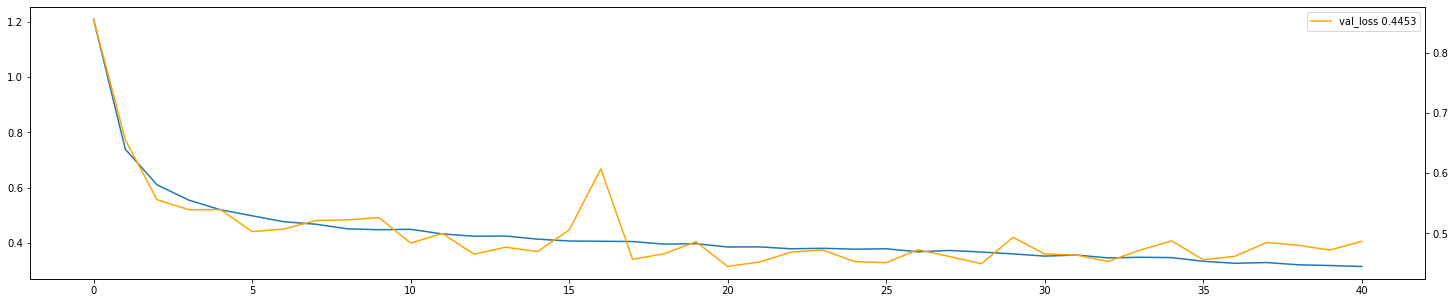

In [9]:
args = [8, 8, 16, 16], [16]
model = train_model(*args)
model.save('/media/guillermo/Data/Kaggle/animalai/agents/004_better_agent/data/model.hdf')

## Summary

1. I have trained a model just on static and moving green food and the accuracy of the models seems to be much better. It is surprising that with a few games it is able to achieve the best score on the evaluation levels.
2. I have added yellow food, static and moving, the score improves a lot, from 0.74 to 0.97.
3. Improve lights off.